## Introduction
This notebook builds an EEGNet model to classify states from EEG data. The process includes the steps: data input, normalization, model construction, training, and evaluation.

In [1]:
import sys
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## Load dataset

In [2]:
df_train = pd.read_csv('/kaggle/input/data-eeg/df_train.csv')
df_test = pd.read_csv('/kaggle/input/data-eeg/df_test.csv')
print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

Train shape: (155822, 204), Test shape: (38956, 204)


## Data preprocessing

In [5]:
def preprocess_data(df, scaler, encoder):
    features = df.drop('state', axis = 1)
    labels = df['state']
    X_scaled = scaler.fit_transform(features)
    y_encoded = encoder.fit_transform(labels)
    return X_scaled, y_encoded

In [6]:
scaler = MinMaxScaler()
encoder = LabelEncoder()

# Prepare training, validation, and test data
X_train_scaled, y_train_encoded = preprocess_data(df_train, scaler, encoder)
X_test, y_test = preprocess_data(df_test, scaler, encoder)

X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_encoded, 
                                                  test_size=0.2, random_state=42, stratify=y_train_encoded)

## Define and Train EEGNet Model

In [ ]:
# Define the EEGNet model
def EEGNet(nb_classes, Chans=7, Samples=29, 
             dropoutRate=0.5, kernLength=64, F1=8, 
             D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    # Block 1
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    # Block 2
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 4))(block2)
    block2       = dropoutType(dropoutRate)(block2)
    
    # Flatten and output    
    flatten      = Flatten(name = 'flatten')(block2)
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [8]:
# Model Parameters
Chans = len(["ED_F7", "ED_F3", "ED_P7", "ED_O1", "ED_O2", "ED_P8", "ED_AF4"])  # useful channels
Samples = df_train.shape[1] // Chans # Number of samples per channel

# Reshape data
X_train = X_train.reshape(-1, Chans, Samples, 1)
X_val = X_val.reshape(-1, Chans, Samples, 1)
X_test = X_test.reshape(-1, Chans, Samples, 1)

# Convert the data labels to one-hot encoded
y_train_onehot = to_categorical(y_train, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

print(f"X_train shape: {X_train.shape}")  # (n_samples_train, Chans, Samples, 1)
print(f"X_val shape: {X_val.shape}")      # (n_samples_val, Chans, Samples, 1)
print(f"X_test shape: {X_test.shape}")      # (n_samples_test, Chans, Samples, 1)

X_train shape: (124657, 7, 29, 1)
X_val shape: (31165, 7, 29, 1)
X_test shape: (38956, 7, 29, 1)


In [ ]:
# Initialize EEGNet model
eeg_net = EEGNet(
    nb_classes=3,       # Number of states: Focused, Unfocused, Drowsy
    Chans=Chans,           # Number of EEG channels
    Samples=Samples,        # Samples per channel
    kernLength=64,      # Kernel temporal: suitable for 128Hz
    F1=16,              # Number of temporal filters
    D=2,                # Spatial Filter
    F2=32,              # Total filter number
    dropoutRate=0.5,    # Dropout to avoid overfitting
    dropoutType='Dropout'
)

# Compile EEGNet model
eeg_net.compile(
    loss='categorical_crossentropy',  # Multi-layer classification
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with low learning rate
    metrics=['accuracy']  # Evaluate by accuracy
)

# Train model
history = eeg_net.fit(
    X_train, 
    y_train_onehot, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, y_val_onehot) # Use validation_data to validate in each epoch
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - accuracy: 0.8848 - loss: 0.3367 - val_accuracy: 0.9759 - val_loss: 0.0936
Epoch 2/50
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.9645 - loss: 0.1097 - val_accuracy: 0.9862 - val_loss: 0.0517
Epoch 3/50
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - accuracy: 0.9714 - loss: 0.0769 - val_accuracy: 0.9928 - val_loss: 0.0379
Epoch 4/50
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - accuracy: 0.9770 - loss: 0.0628 - val_accuracy: 0.9918 - val_loss: 0.0339
Epoch 5/50
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.9787 - loss: 0.0565 - val_accuracy: 0.9907 - val_loss: 0.0308
Epoch 6/50
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.9811 - loss: 0.0501 - val_accuracy: 0.9917 - val_loss: 0.0267
Epoch 7/50
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.9821 - loss: 0.0469 - val_accuracy: 0.9923 - val_loss: 0.0246
Epoch 8/50
3896/3896 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.9841 -

## Evaluation

In [10]:
# Evaluate the model on the test set
y_pred = np.argmax(eeg_net.predict(X_test), axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(f"Classification Report:")
print(classification_report(y_pred, y_test))

1218/1218 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Accuracy: 0.9947376527364206
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22863
           1       0.99      1.00      0.99      7991
           2       0.99      0.99      0.99      8102

    accuracy                           0.99     38956
   macro avg       0.99      0.99      0.99     38956
weighted avg       0.99      0.99      0.99     38956



## Visualization
#### Confusion matrix

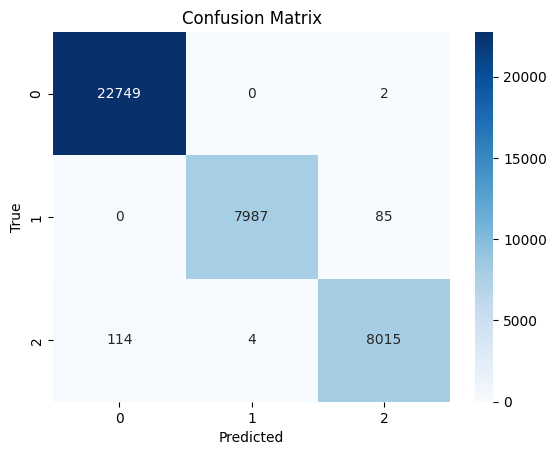

In [11]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### ROC curve

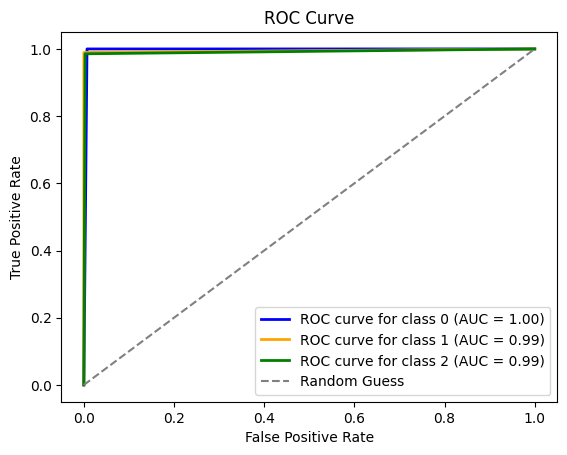

In [12]:
y_pred_onehot = to_categorical(y_pred, num_classes=3)

n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'orange', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC curve for class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()